# MFS Interview Case Study: Employee Turnover Prediction
Erin Keough\
22 October 2025\
erinkeough@ymail.com

**Business Question**: Can we predict which employees are most at risk of attrition, so HR can take proactive steps to improve retention?

**Business Value**:
- Reduce attrition costs (for example, recruiting, training, knowledge loss)
- Improve retention of high-performing employees
- Data-driven workforce planning

## Assumptions

In modeling employee turnover with this IBM HR Attrition dataset, we are implicitly making several assumptions, which I will categorize into Data, Modeling, and Business Assumptions.

**Data Assumptions**

*Representative Sample of Employees*
* We assume that the IBM dataset represents the population of employees we want to make predictions for, but since this is mock data, it may not reflect real-world HR dynamics

*Sampling Bias & Completeness*
* We assume the data has not excluded certain groups (e.g., interns, senior executives); if sampling bias exists, this could lead to over- or under-predicting for certain groups
* We also assume that all columns are measured correctly and consistently (e.g., satisfaction fields), when in reality, HR survey data is often missing

*Temporal Stability & Stationarity*
* A large assumption made with this dataset is that the relationships between features and attrition remain stable over time, when things like management or policy changes can alter employee satisfaction features dramatically

**Modeling Assumptions**

*Class Balance*
* The dataset is very class-imbalanced (i.e., attrition is relatively rare), thus we assume model metrics are still valid under class imbalance

*Feature Independence*
* Models like Logistic Regression assume features are not strongly correlated, however, there are predictors like 'MonthlyIncome' and 'JobLevel' which are inherently correlated and can thus distort coefficients

*Independent & Identically Distributed (IID) Samples*
* Most algorithms assume each employee in the dataset is independent from the others, when in reality, some will inevitably be linked. For example, employees on the same team or who share a manager may not be independent, as they share their environment and leadership

**Business Assumptions**

*Actionable Predictions & Causality Direction*
* We assume that model patterns like 'low job satisfaction leads to higher attrition risk' are inherently actionable, but it is possible that these conditions are instead caused by an unmeasured factor like poor management
* We also assume features must influence attrition and not the other way around; for example, low performance ratings may occur because the employee was already planning to leave, rather than the low performance rating causing the employee to leave

*Ethical & Privacy Considerations*
* We are assuming that using these features for prediction is ethical and complies with privacy standards, like not using demographic information in ways that could create bias

## Methodology Overview

After loading the requisite libraries for data manipulation, visualization, and modeling, the following steps will be taken to predict employee turnover:
1. Load the dataset (stored locally) and explore its contents
2. Exploratory Data Analysis (EDA) to discover trends between predictors and the target variable, Attrition
3. Preprocessing the data to prepare it for modeling & creating features that enhance analysis
4. Modeling to predict employee turnover, wherein I have chosen to compare the following 5 models to determine which best performs the prediction task: XGBoost, Gradient Boosted Tree, Random Forest, Logistic Regression, and Support Vector Machine (SVM)
5. Explainability for the models by extracting the features which were most important in predicting attrition
6. Exporting the resulting datasets for use in Tableau

### Step 0: Load required libraries
In this section, I will import all packages and libraries required for data handling, visualization, and modeling.

In [1]:
# Base packages/libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling packages/libraries:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, DMatrix, cv as xgb_cv, train as xgb_train
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay)

In [2]:
# Ignore warnings:
import warnings
warnings.filterwarnings('ignore')

### Step 1: Load & explore dataset
Next, I will load the IBM Employee Attrition dataset, view the first 5 rows of data to get a sense of its structure, and use the ```.info()``` method to view the column types and number of non-null values in each.

In [4]:
# Load sample dataset
data = pd.read_csv("01-IBMAttritionData_raw.csv")
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Column non-null count & data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

### Step 2: Exploratory Data Analysis (EDA)

**Variable Relationships**

I will begin performing EDA by visualizing relationships between various features and the explanatory variable, Attrition.

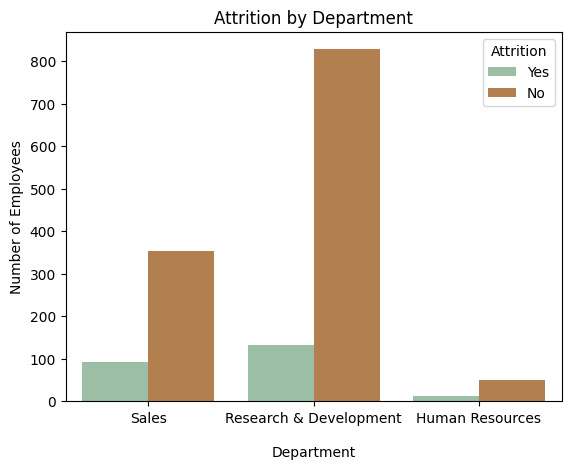

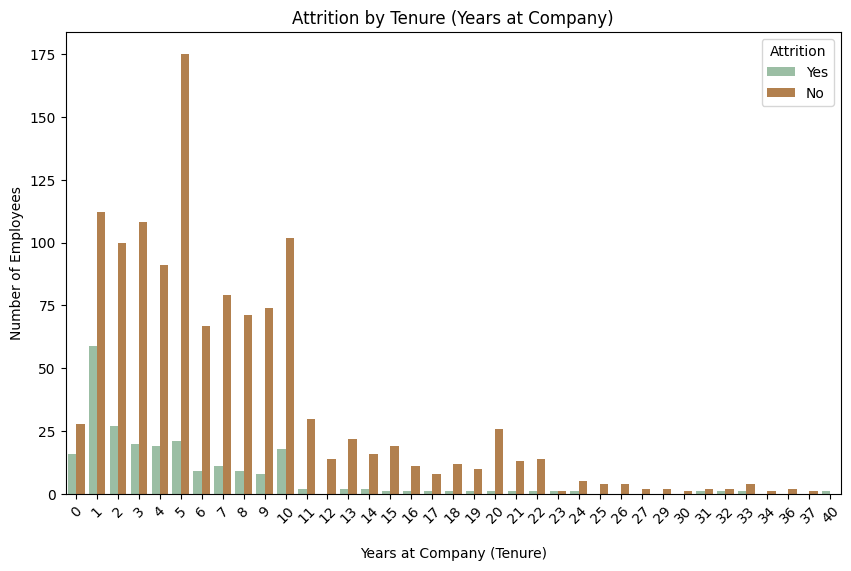

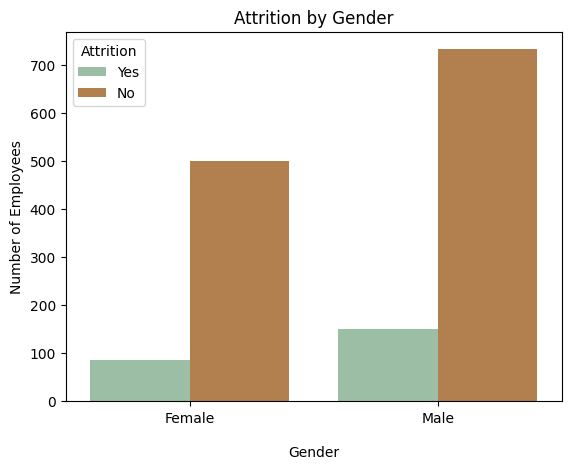

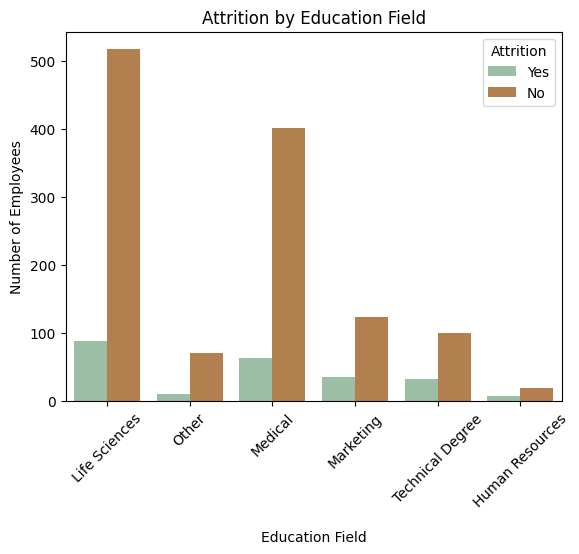

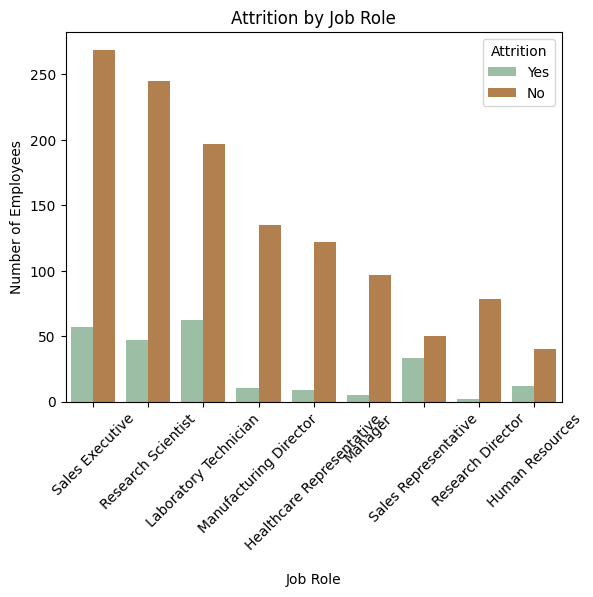

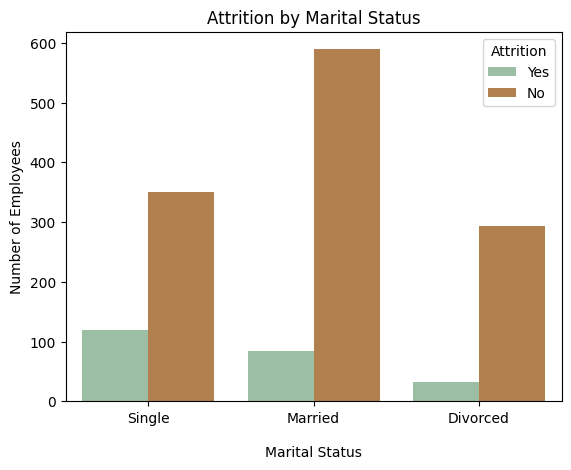

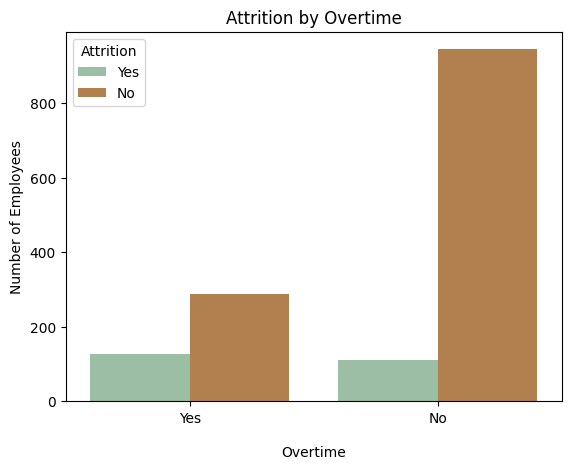

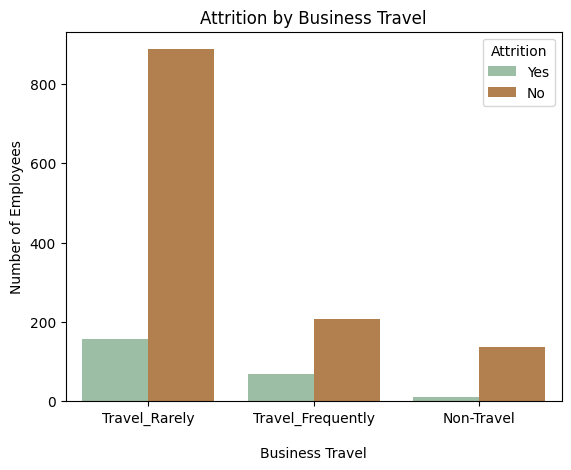

In [5]:
## Categorical Variables: sns.countplot

# Presentation palette
colors = ['#95C4A1', '#C3803D']

# Attrition by Department
sns.countplot(data = data, x = "Department", hue = "Attrition", palette = colors)
plt.title("Attrition by Department")
plt.xlabel("Department", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Tenure
plt.figure(figsize = (10, 6))
sns.countplot(data = data, x = "YearsAtCompany", hue = "Attrition", palette = colors)
plt.title("Attrition by Tenure (Years at Company)")
plt.xlabel("Years at Company (Tenure)", labelpad = 15)
plt.ylabel("Number of Employees")
plt.xticks(rotation = 45)
plt.show()

# Attrition by Gender
sns.countplot(data = data, x = "Gender", hue = "Attrition", palette = colors)
plt.title("Attrition by Gender")
plt.xlabel("Gender", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Education Field
sns.countplot(data = data, x = "EducationField", hue = "Attrition", palette = colors)
plt.title("Attrition by Education Field")
plt.xlabel("Education Field", labelpad = 15)
plt.ylabel("Number of Employees")
plt.xticks(rotation = 45)
plt.show()

# Attrition by Job Role
sns.countplot(data = data, x = "JobRole", hue = "Attrition", palette = colors)
plt.title("Attrition by Job Role")
plt.xlabel("Job Role", labelpad = 15)
plt.ylabel("Number of Employees")
plt.xticks(rotation = 45)
plt.show()

# Attrition by Marital Status
sns.countplot(data = data, x = "MaritalStatus", hue = "Attrition", palette = colors)
plt.title("Attrition by Marital Status")
plt.xlabel("Marital Status", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Overtime
sns.countplot(data = data, x = "OverTime", hue = "Attrition", palette = colors)
plt.title("Attrition by Overtime")
plt.xlabel("Overtime", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Business Travel
sns.countplot(data = data, x = "BusinessTravel", hue = "Attrition", palette = colors)
plt.title("Attrition by Business Travel")
plt.xlabel("Business Travel", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

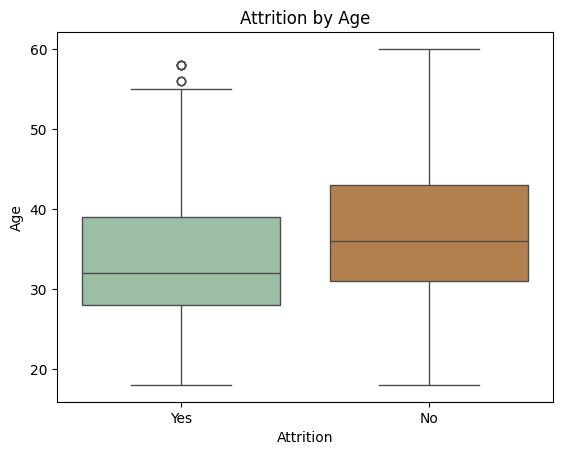

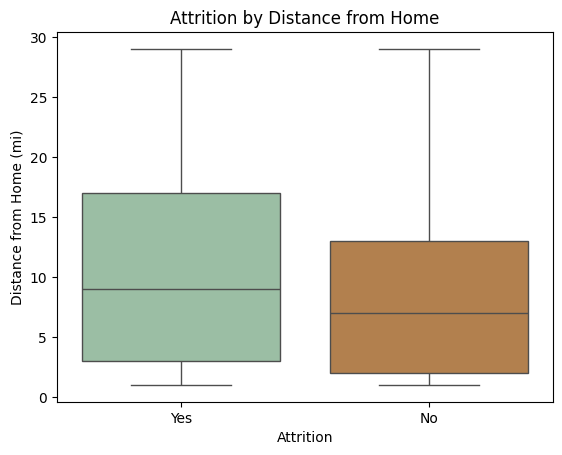

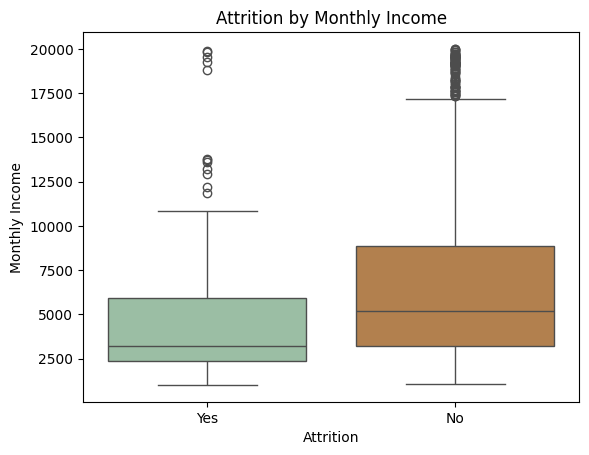

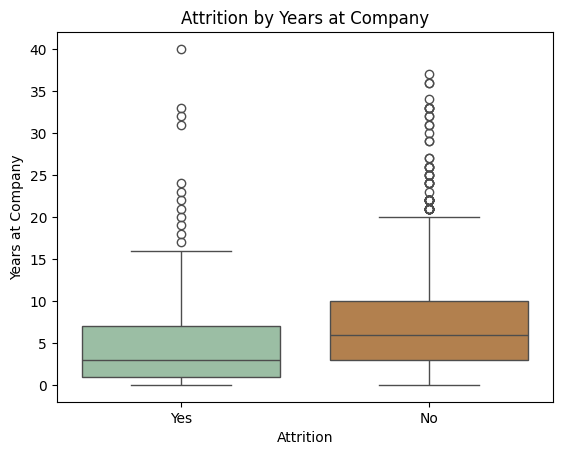

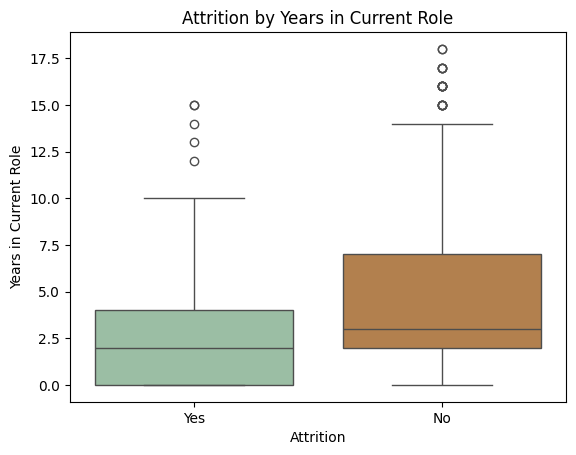

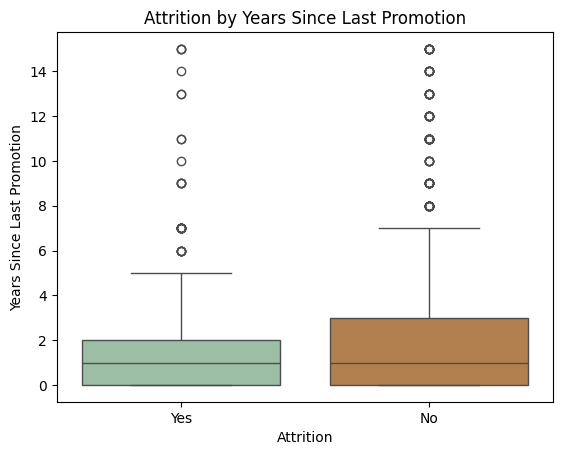

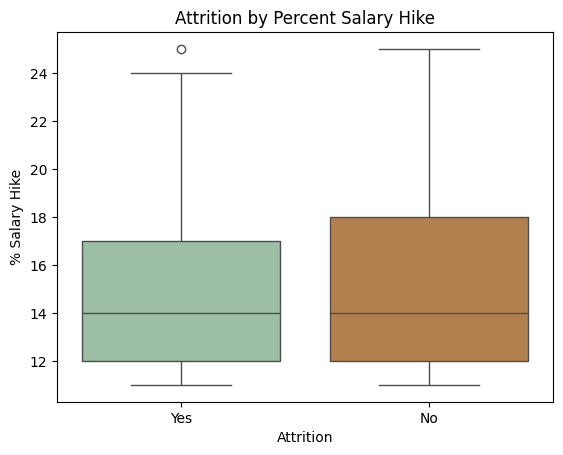

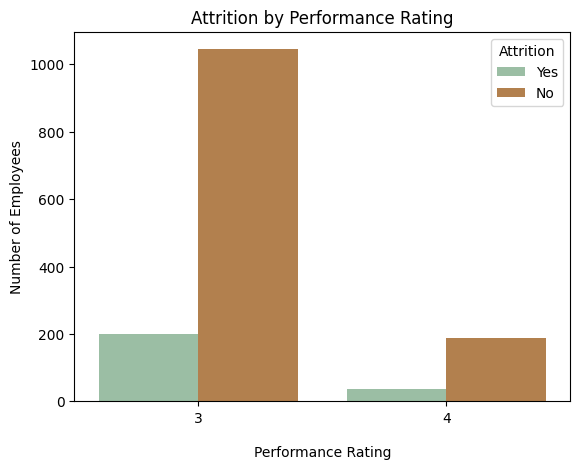

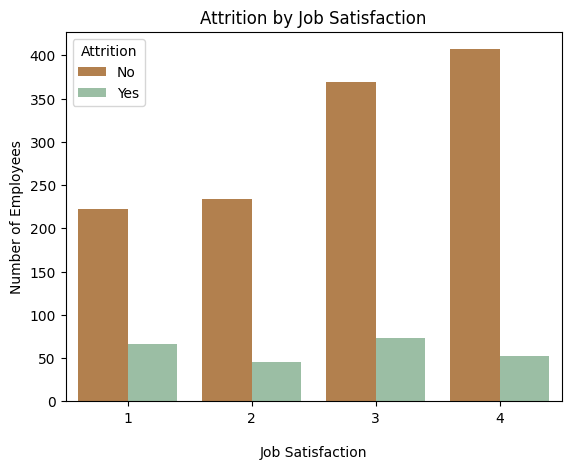

In [6]:
## Numerical Variables: sns.boxplot & sns.countplot

# Attrition by Age
sns.boxplot(y = 'Age', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Age")
plt.ylabel("Age")
plt.show()

# Attrition by Distance from Home
sns.boxplot(y = 'DistanceFromHome', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Distance from Home")
plt.ylabel("Distance from Home (mi)")
plt.show()

# Attrition by Monthly Income
sns.boxplot(y = 'MonthlyIncome', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Monthly Income")
plt.ylabel("Monthly Income")
plt.show()

# Attrition by Years at Company
sns.boxplot(y = 'YearsAtCompany', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Years at Company")
plt.ylabel("Years at Company")
plt.show()

# Attrition by Years in Current Role
sns.boxplot(y = 'YearsInCurrentRole', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Years in Current Role")
plt.ylabel("Years in Current Role")
plt.show()

# Attrition by Years Since Last Promotion
sns.boxplot(y = 'YearsSinceLastPromotion', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Years Since Last Promotion")
plt.ylabel("Years Since Last Promotion")
plt.show()

# Attrition by Percent Salary Hike
sns.boxplot(y = 'PercentSalaryHike', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Percent Salary Hike")
plt.ylabel("% Salary Hike")
plt.show()

# Attrition by Performance Rating
sns.countplot(data = data, x = "PerformanceRating", hue = "Attrition", palette = colors)
plt.title("Attrition by Performance Rating")
plt.xlabel("Performance Rating", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Job Satisfaction
sns.countplot(data = data, x = "JobSatisfaction", hue = "Attrition", palette = [colors[1], colors[0]])
plt.title("Attrition by Job Satisfaction")
plt.xlabel("Job Satisfaction", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

**Correlation Heatmap**

Next, I will visualize the correlations between all numeric variables in the dataset with a correlation heatmap.

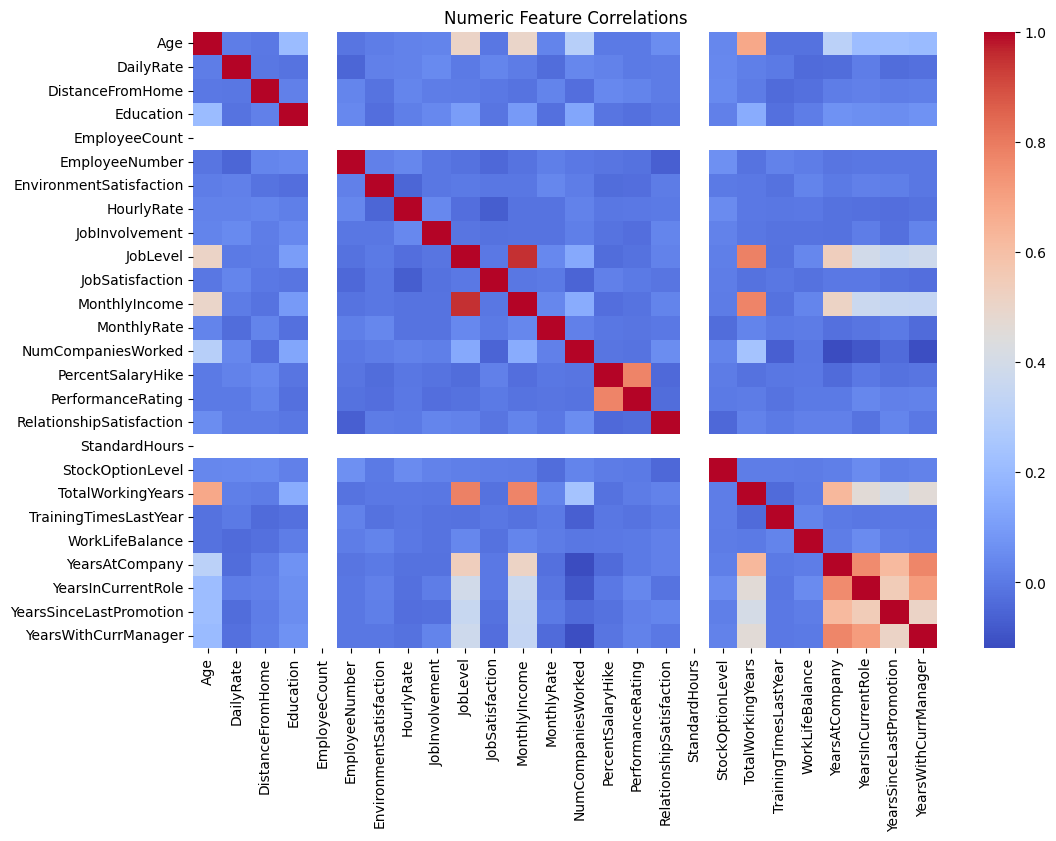

In [7]:
num_data = data.select_dtypes(include=['int64'])

# Correlation heatmap
plt.figure(figsize = (12, 8))
sns.heatmap(num_data.corr(), cmap = "coolwarm")
plt.title("Numeric Feature Correlations")
plt.show()

### Step 3: Preprocessing & Feature Engineering
In this step, I will clean up the dataset to prepare it for and modeling. 

From Step 1 above, we can see that each column contains 1,407 non-null values of varying types. In other words, there are no missing values to omit or impute. However, from the column distributions found on the [Kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset) webpage for this dataset, I have found that the following variables do not add value to the analysis and can thus be removed from the dataset: 
1. ```EmployeeCount```: This variable represents the "count" of each employee represented by a row in the dataset, i.e., the value is 1 in each row
2. ```EmployeeNumber```: An arbitrary number is assigned to each employee in the dataset; this number does not lend useful information for the analysis
3. ```Over18```: All employees in the dataset are over the age of 18, thus the value is "Yes" in each row
4. ```StandardHours```: All employees work 80 hours biweekly, resulting in the value of 80 in each row

I will then encode the target variable, Attrition, as ```Yes = 1``` and ```No = 0```, and generate some features that I believe will lend greater insight to the analysis. 

In [5]:
# Drop EmployeeCount, EmployeeNumber, Over18, and StandardHours
data.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis = 1, inplace = True)

# Encode target variable: Attrition
data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x == "Yes" else 0)

#### Feature Engineering

**Overall Satisfaction**

The variables ```JobInvolvement```, ```WorkLifeBalance```, ```JobSatisfaction```, ```RelationshipSatisfaction```, and ```EnvironmentSatisfaction```, each represented as a rating on a scale of 1-5, may be averaged together to create a variable ```OverallSatisfaction```.

In [6]:
# Overall Satisfaction: Average of job involvement, work-life balance, and job, relationship, and environment satisfaction
data['OverallSatisfaction'] = (data['JobInvolvement'] + data['WorkLifeBalance'] + data['JobSatisfaction'] +
                               data['RelationshipSatisfaction'] + data['EnvironmentSatisfaction']) / 5

# Drop individual satisfaction fields
data.drop(['JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction', 'RelationshipSatisfaction', 'EnvironmentSatisfaction'], 
          axis = 1, inplace = True)

**Income**

This dataset contains several "rate" and "income" fields that can introduce redundancy when it comes to modeling. Thus, I will replace these fields with a categorical ```Income``` feature based on the ```MonthlyIncome``` variable, assigning each row to either Low, Medium, or High income categories. 

In [7]:
# Income field calculated using pandas qcut function
data['Income'] = pd.qcut(data['MonthlyIncome'], q = 3, labels = ['Low', 'Medium', 'High'])

# Drop original 'rate' and 'income' fields
data.drop(['DailyRate', 'MonthlyRate', 'MonthlyIncome', 'HourlyRate'], axis = 1, inplace = True)

**Promotion Ratio**

In looking at the time since last promotion, I notice this could be further enriched by expressing the value as a ratio of the employee's total time working at the company. Therefore, I will create a ```PromotionRatio``` feature defined as ```YearsSinceLastPromotion```/```YearsAtCompany``` (correcting for instances of ```YearsAtCompany = 0```).

In [8]:
data['PromotionRatio'] = data['YearsSinceLastPromotion'] / data['YearsAtCompany'].replace(0, 1)

#### Step 4: Modeling

In this step, I will develop the candidate models for predicting employee turnover. The following models have been chosen to be assessed for this case study, along with their rationale & strengths:
1. ```XGBoost```: Often out-performs other models in terms of accuracy for predicting outcomes like employee turnover
2. ```Random Forest```: An ensemble method that combines multiple decision trees; known for its high predictive accuracy
3. ```Gradient Boosted Tree```: Another powerful ensemble method that can capture complex, non-linear relationships in data
4. ```Logistic Regression```: A common and effective baseline model for binary classification tasks (e.g., predicting "stay" or "leave")
5. ```Support Vector Machines (SVM)```: Effective for binary classification, with both linear and non-linear versions available

**Data Prep**

In [9]:
# Separate target from predictors
X = data.drop("Attrition", axis = 1)
y = data["Attrition"]

# Identify numeric and categorical variables
numeric = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical = X.select_dtypes(include = ['object', 'category']).columns.tolist()

print("Numeric columns:", numeric)
print("Categorical columns:", categorical)

Numeric columns: ['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'OverallSatisfaction', 'PromotionRatio']
Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Income']


In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

**Pre-processing Pipeline**

In [11]:
# Create pipelines to impute and encode numeric and categorical variables
numeric_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median')),
                                      ('scaler', StandardScaler())])
categorical_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
                                          ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))])

# Create preprocessor
preprocessor = ColumnTransformer(transformers=[('num', numeric_trans, numeric), ('cat', categorical_trans, categorical), ], remainder='drop')

**Model Training & Evaluation**

In [12]:
# Define a dictionary to store model classifiers
models = {
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42),
    'RandomForest': RandomForestClassifier(random_state = 42),
    'GradientBoosting': GradientBoostingClassifier(random_state = 42),
    'LogisticRegression': LogisticRegression(max_iter = 1000, solver = 'lbfgs', random_state = 42),
    'SVM': SVC(probability = True, random_state = 42)
}

In [13]:
### In this block, I will iterate through each model in the 'models' dictionary,
### train the model, and evaluate it on the test set.

# Establish an empty list to store results
results = []

for name, model in models.items():
    print(f"\nTraining and evaluating: {name}")
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Fit on training data
    pipe.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = pipe.predict(X_test)

    # Probability estimates for each class label (note: some models do not implement 'predict_proba' function,
    # in these cases the second 'try' statement will be executed)
    try:
        y_proba = pipe.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except Exception as e:
        try:
            y_score = pipe.decision_function(X_test)
            roc_auc = roc_auc_score(y_test, y_score)
        except Exception:
            roc_auc = np.nan

    # Store & print model performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division = 0)
    rec = recall_score(y_test, y_pred, zero_division = 0)
    f1 = f1_score(y_test, y_pred, zero_division = 0)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy: {:.4f}  Precision: {:.4f}  Recall: {:.4f}  F1: {:.4f}  ROC AUC: {:.4f}".format(
        acc, prec, rec, f1, roc_auc if not np.isnan(roc_auc) else -1))
    print("Confusion matrix:\n", cm)
   
    print(classification_report(y_test, y_pred))

    # Append model results to 'results'
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    })


Training and evaluating: XGBoost
Accuracy: 0.8367  Precision: 0.4848  Recall: 0.3404  F1: 0.4000  ROC AUC: 0.7313
Confusion matrix:
 [[230  17]
 [ 31  16]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       247
           1       0.48      0.34      0.40        47

    accuracy                           0.84       294
   macro avg       0.68      0.64      0.65       294
weighted avg       0.82      0.84      0.82       294


Training and evaluating: RandomForest
Accuracy: 0.8401  Precision: 0.5000  Recall: 0.1064  F1: 0.1754  ROC AUC: 0.7840
Confusion matrix:
 [[242   5]
 [ 42   5]]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.50      0.11      0.18        47

    accuracy                           0.84       294
   macro avg       0.68      0.54      0.54       294
weighted avg       0.80      0.84      0.79       294


Training and evaluating: G

**Results Summary**

In [14]:
# Iterate through 'results' and compile metrics in a dataframe
results_df = pd.DataFrame([{
    'Model': r['model'],
    'Accuracy': r['accuracy'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'F1': r['f1'],
    'ROC_AUC': (r['roc_auc'] if not np.isnan(r['roc_auc']) else None)
} for r in results])

print("Model performance summary:")
display(results_df)

Model performance summary:


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,XGBoost,0.836735,0.484848,0.340426,0.400000,0.731329
1,RandomForest,0.840136,0.500000,0.106383,0.175439,0.784004
2,GradientBoosting,0.829932,0.440000,0.234043,0.305556,0.789474
3,LogisticRegression,0.870748,0.680000,0.361702,0.472222,0.820053
4,SVM,0.860544,0.750000,0.191489,0.305085,0.814971


**ROC-AUC Curves**

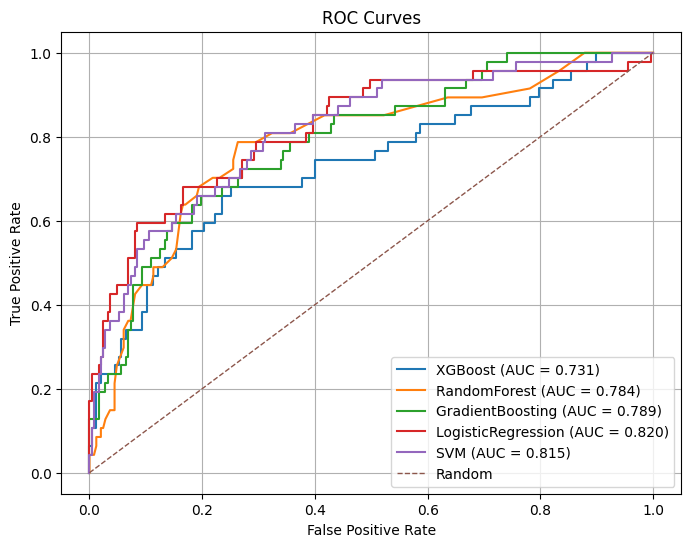

In [15]:
plt.figure(figsize=(8, 6))
from sklearn.metrics import roc_curve, auc
for r in results:
    name = r['model']
    
    # Rebuild the pipeline to get probability of class label (if ROC_AUC is not NaN)
    if r['roc_auc'] is not None and not np.isnan(r['roc_auc']):
        pipe = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', models[name])])
        pipe.fit(X_train, y_train)
        y_proba = pipe.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label = f"{name} (AUC = {roc_auc_score(y_test, y_proba):.3f})")

plt.plot([0, 1], [0, 1], linestyle = '--', linewidth = 1, label = 'Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

### Step 5: Explainability

To enhance the explainability of the modeling results, I will extract and plot the feature importances for the tree-based models and logistic regression coefficients. Note that the Support Vector Machines (SVM) model does not natively provide simple feature importances, thus the outcome will be four bar charts.


XGBoost Feature Importance:


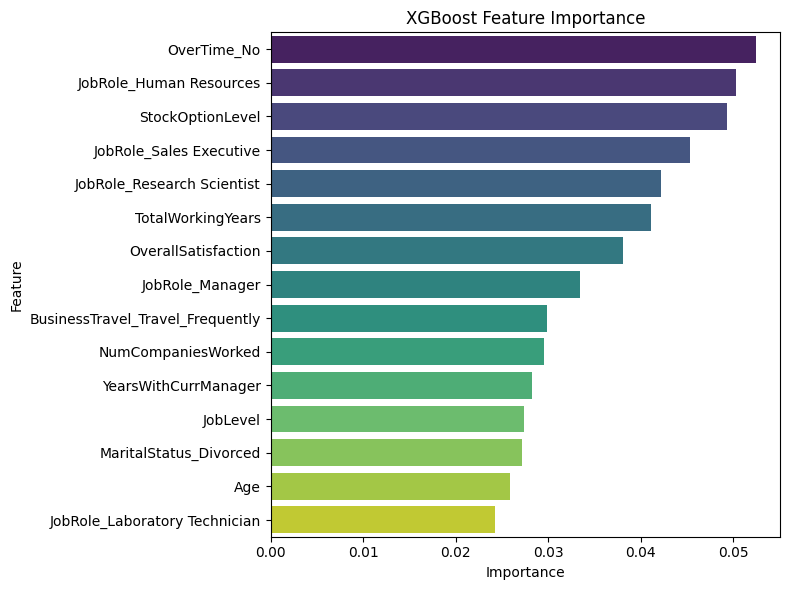


RandomForest Feature Importance:


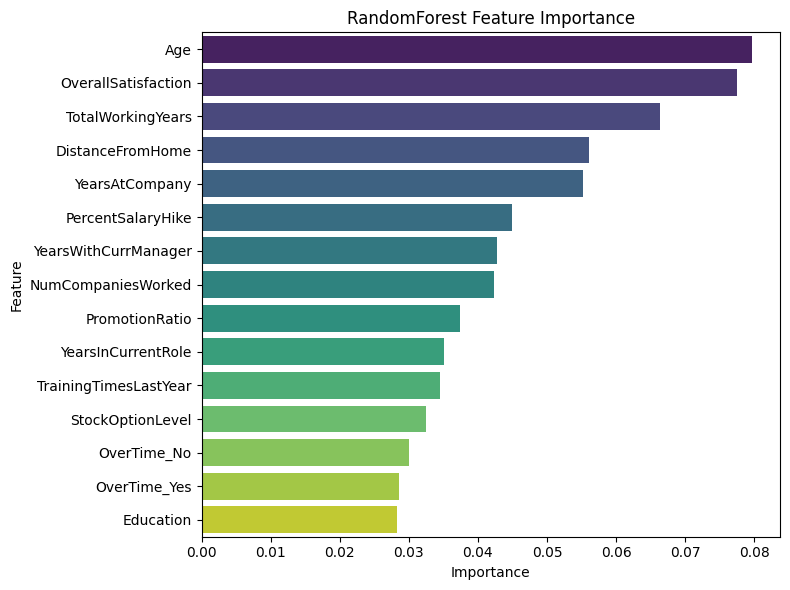


GradientBoosting Feature Importance:


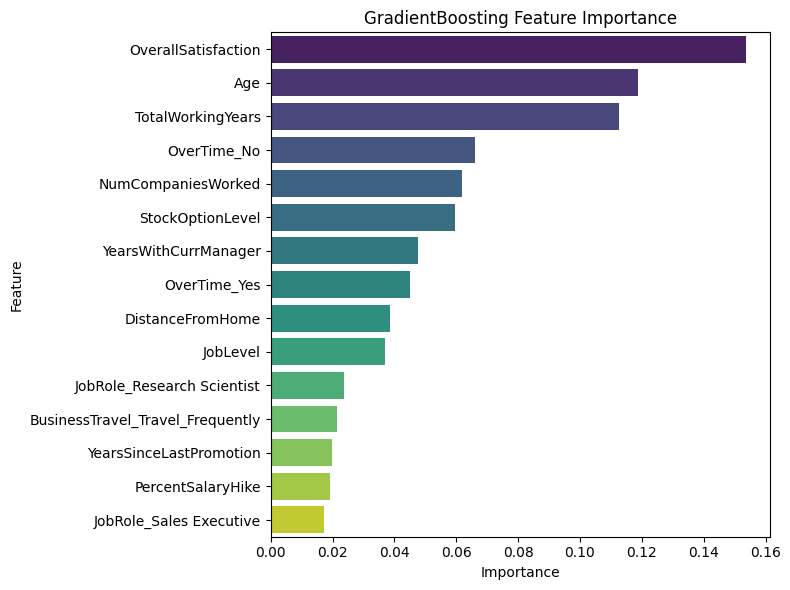


LogisticRegression Feature Importance:


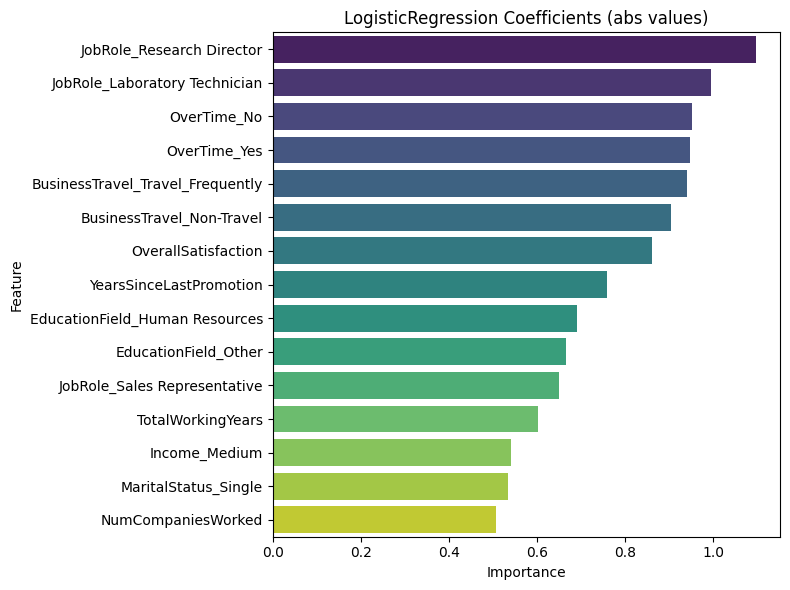

In [16]:
# Transform training data to get feature names post-preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical)
feature_names = numeric + list(cat_feature_names)

# Define a function for repeatability that plots feature importance
def plot_feature_importance(importances, feature_names, title):
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values(by = 'importance', ascending = False).head(15)
    plt.figure(figsize=(8, 6))
    sns.barplot(x='importance', y='feature', data=fi, palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Refit tree-based and linear models directly on transformed data for importance extraction
for name, model in models.items():
    if name == 'SVM':
        continue  # SVM does not provide simple feature importance
    print(f"\n{name} Feature Importance:")
    model.fit(X_train_transformed, y_train)

    if hasattr(model, 'feature_importances_'): # If the model has 'feature importance' attribute
        plot_feature_importance(model.feature_importances_, feature_names, f"{name} Feature Importance")
    elif hasattr(model, 'coef_'): # If the model has 'coef' attribute
        importances = np.abs(model.coef_[0])
        plot_feature_importance(importances, feature_names, f"{name} Coefficients (abs values)")
    else: # If the type of model does not yield feature importances
        print(f"{name} does not support feature importance extraction.")

### Step 6: Save output files to CSV

In [17]:
# Write model comparison results to a CSV
results_df.to_csv("03-ModelComparison.csv", index = False)

# Iterate through models and store feature importances
feature_importances_list = []
for name, model in models.items():
    if name == 'SVM':
        continue  # Skip SVM since it does not provide importances
    model.fit(X_train_transformed, y_train)

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        continue

    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by = 'Importance', ascending = False)

    # Save each model’s importances to its own CSV file
    filename = f"{name}-FeatureImportance.csv"
    fi_df.to_csv(filename, index=False)
    print(f"Saved {filename} ({len(fi_df)} features)")

    # Store for combined summary 
    fi_df['Model'] = name
    feature_importances_list.append(fi_df)

Saved XGBoost-FeatureImportance.csv (47 features)
Saved RandomForest-FeatureImportance.csv (47 features)
Saved GradientBoosting-FeatureImportance.csv (47 features)
Saved LogisticRegression-FeatureImportance.csv (47 features)


In [18]:
# Combine all model importances into one dataframe
combined_fi_df = pd.concat(feature_importances_list, ignore_index = True)
combined_fi_df.to_csv("04-FeatureImportance-AllModels.csv", index = False)